# Installation

Install all the dependencies to make the most out of docTR. The project provides two main [installation](https://mindee.github.io/doctr/latest/installing.html) streams: one for stable release (update once every 45 days on average), and developer mode.

## Latest stable release

This will install the last stable release of docTR.

In [3]:
# TensorFlow
# !pip install python-doctr[tf]
# PyTorch
!pip install python-doctr[torch]

In [4]:
%matplotlib inline
import os

# Let's pick the desired backend
os.environ['USE_TORCH'] = '1'

import matplotlib.pyplot as plt

from doctr.io import DocumentFile
from doctr.models import ocr_predictor

/home/said/anaconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Read the file
doc = DocumentFile.from_images("/home/said/courses/Projetinfo/sports_scr/data/natation/ROI/CLIP_visual_prompt/000006.png")

In [6]:
# Instantiate a pretrained model
predictor = ocr_predictor(pretrained=True, export_as_straight_boxes=True)

/home/said/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/said/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Basic inference

In [7]:
result = predictor(doc)

## Prediction visualization

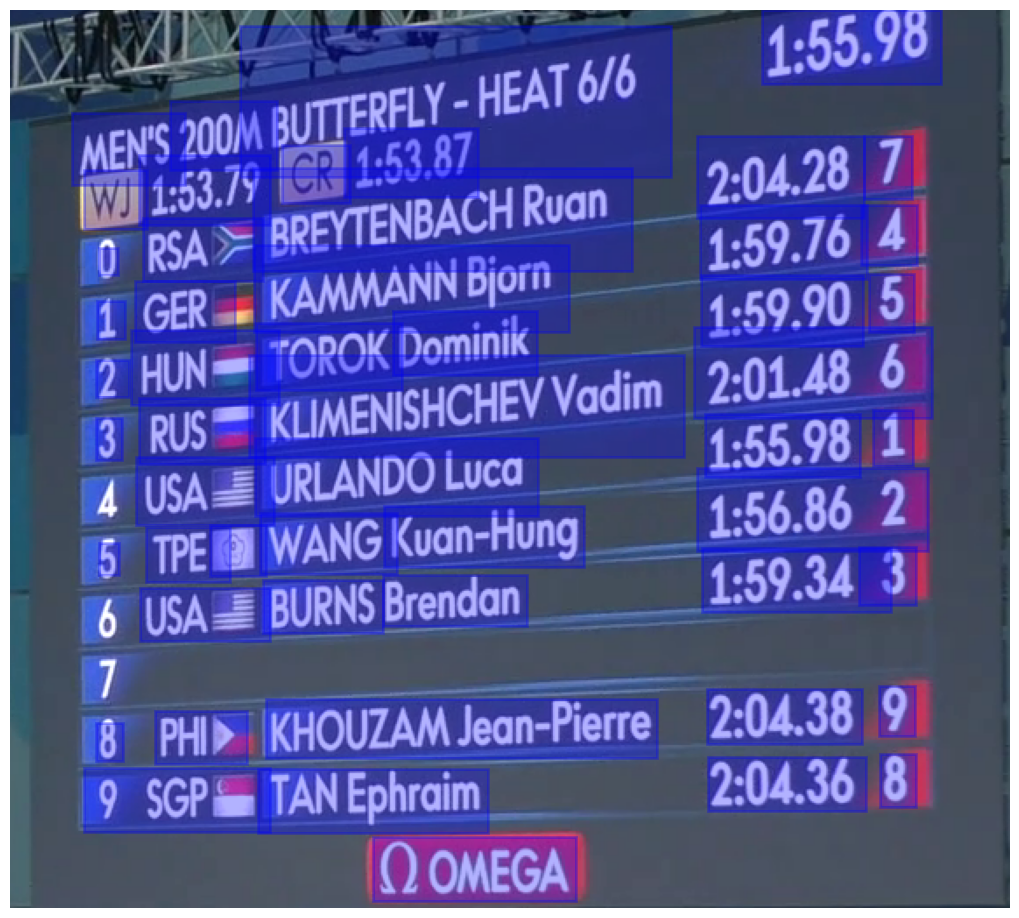

In [8]:
result.show(doc)

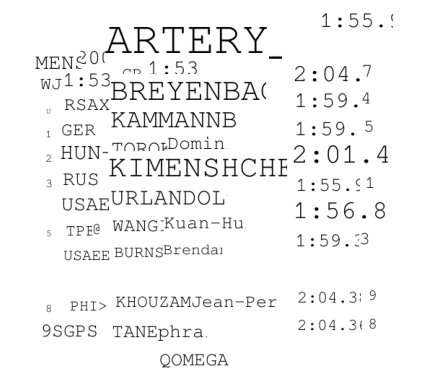

In [9]:
synthetic_pages = result.synthesize()
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()

## Exporting results

In [10]:
# JSON export
json_export = result.export()['pages'][0]["blocks"]

In [11]:
def reformat_doctr(raw_predictions):
    predictions = ''
    for block in raw_predictions:
        for line in block['lines']:
            for word in line['words']:
                predictions += f"{word['value']} "
            predictions += '\n'
        predictions += '===\n'
    return predictions.split('\n')

In [12]:
predictions = reformat_doctr(json_export)

In [13]:
def get_champions_names(sport="natation"):
    dic_names = {}
    with open("../data/champions/natation.txt", "r") as file:
        for line in file.readlines():
            last_name, first_name = line.strip().split()
            dic_names[last_name] = first_name
    return dic_names

In [14]:
dic_names = get_champions_names(sport="natation")

In [32]:
import re
import editdistance

def extract_names(input_string, min_edit_distance=2):
    # Define the regular expression pattern
    name_pattern = r"[A-Z]+ [A-Z][a-z]+"
    time_pattern = r"(?:\d+:)?\d+[.,]\d{2}"

    # Use the re.findall() function to find all matches in the input string
    name_matches = re.findall(name_pattern, input_string, re.MULTILINE)

    # Extract the names from the matches
    last_first_name_map = {}
    for match in name_matches:
        # Split the match into its constituent parts
        parts = match.split()
        print(match)
        # Extract the name
        name = " ".join(parts[:-1])

        last_first_name_map[name] = parts[-1]

    # Use the re.findall() function to find all matches in the input string
    time_matches = re.findall(time_pattern, input_string, re.MULTILINE)
    
    # Extract the names from the matches
    times = []
    for match in time_matches:
        # Split the match into its constituent parts
        parts = match.split()
        # Extract the name
        time = parts[0]
        times.append(time)
    
    # Filter names
    good_names = []
    for name in last_first_name_map.keys():
        for dic_name in dic_names.keys():
            if editdistance.eval(name, dic_name) <= min_edit_distance:
                good_names.append(name)
            else:
                pass
    
    try :
        times = times[::-1]
        good_times = times[0:len(good_names)]
    except:
        good_times = times[0:len(good_names)]
    
    good_first_names = [v for k, v in last_first_name_map.items() if k in good_names]
    # final result : Last Name, First Name, Time
    result = [f"{last} {first} {time}" for last, first, time in zip(good_names, good_first_names, good_times)]
    return result

In [33]:
input_string = " ".join(predictions)

result = extract_names(input_string)

TOROKI Dominik
WANGI Kuan
BURNS Brendan


In [38]:
import re

text = "Here are some names: TOROKIDominik, JOHNDoe, JANESmith."

# Define the regular expression pattern
pattern = r"([A-Z]+)([A-Z][a-z]*)"

# Find all words that match the pattern
matches = re.findall(pattern, text)

# Replace each match with the desired format
for match in matches:
    old_word = ''.join(match)
    new_word = ' '.join(match)
    text = text.replace(old_word, new_word)

print(text)


Here are some names: TOROKI Dominik, JOHN Doe, JANE Smith.


In [34]:
result

['TOROKI Dominik 2:04.36', 'WANGI Kuan 2:04.38', 'BURNS Brendan 1:59.34']

In [ ]:
def separate_cursed_names(string):
    # Define the regular expression pattern
    pattern = r"([A-Z]+)([A-Z][a-z]*)"

    # Find all words that match the pattern
    matches = re.findall(pattern, string)

    # Replace each match with the desired format
    for match in matches:
        old_word = ''.join(match)
        new_word = ' '.join(match)
        string = string.replace(old_word, new_word)

    return string

In [22]:
predictions

['1:55.98 ',
 '===',
 '200MI ',
 '===',
 'ARTERY_HEAT46 ',
 '===',
 'MENS WJ 1:53.79 CR 1:53.87 ',
 '===',
 '2:04.28 7 ',
 '===',
 'U ',
 '===',
 'RSAX BREYENBACHRuon ',
 '===',
 '1:59.76 4 ',
 '===',
 'KAMMANNBjorn ',
 '===',
 '1 GER ',
 '===',
 '1:59.90 5 ',
 '===',
 '2 HUN- TOROKI Dominik ',
 '===',
 '2:01.486 ',
 '===',
 '3 ',
 '===',
 'RUS KIMENSHCHEYVodin 1:55.98 1 ',
 '===',
 'USAE URLANDOLuca ',
 '===',
 '1:56.862 ',
 '===',
 '5 TPEK @ WANGI Kuan-Hung ',
 '===',
 '1:59.34 3 ',
 '===',
 'USAEE BURNS Brendan ',
 '===',
 '9 ',
 '===',
 '8 PHI> KHOUZAMJean-Pere ',
 '===',
 '2:04.38 ',
 '===',
 '9SGPS TANEphraim ',
 '===',
 '2:04.36 8 ',
 '===',
 'QOMEGA ',
 '===',
 '']